In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.naive_bayes import GaussianNB


## Preprocessing

>#### load 'weather_forecast_data.csv' dataset

In [2]:
df = pd.read_csv('weather_forecast_data.csv')

In [3]:
# get copy from the original to preprocess

df_pre = df.copy()

>#### check missing values

In [4]:
# to know the number of the rows
print(f"total records:",len(df), "\n")


# to get the number of missing values in each column
print("missing records in each column:","\n")
print(df_pre.isnull().sum())

print("-"*80)

print("Records with null values: ","\n")
print(df_pre[df_pre.isnull().any(axis=1)])

# according to the output there are missing values



total records: 2500 

missing records in each column: 

Temperature    25
Humidity       40
Wind_Speed     32
Cloud_Cover    33
Pressure       27
Rain            0
dtype: int64
--------------------------------------------------------------------------------
Records with null values:  

      Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
8             NaN  89.077804    4.842197    83.941093  1029.932706  no rain
25      26.420959  72.283460         NaN     0.812305  1018.818494  no rain
59      11.069078  89.683583    5.804538          NaN   992.303157  no rain
68            NaN  58.981077    6.261278    37.580222  1019.684713  no rain
74      33.078976  81.000650    5.744880    86.933978          NaN  no rain
...           ...        ...         ...          ...          ...      ...
2429          NaN  93.920582   13.302477    90.346087   998.183246     rain
2436    16.838551  86.248171   13.326615          NaN  1004.497445     rain
2445    14.279301        NaN 

>#### Handle missing values with dropping them

In [5]:

df_dropped_nulls= df_pre.dropna()
print(f"total records without nulls:",len(df_dropped_nulls), "\n")

df_dropped_nulls.head()

total records without nulls: 2347 



,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,19.096119,71.651723,14.782324,48.699257,987.954760,no rain
1,27.112464,84.183705,13.289986,10.375646,1035.430870,no rain
2,20.433329,42.290424,7.216295,6.673307,1033.628086,no rain
3,19.576659,40.679280,4.568833,55.026758,1038.832300,no rain
4,19.828060,93.353211,0.104489,30.687566,1009.423717,no rain


>#### Handle missing values with replacing them with Avg

In [6]:
# get the numerical features only because we can't get mean for categorical feature
df_numerical_features_only=df_pre.select_dtypes(include="number")

# replace the null values with the average of the numerical features
df_numerical_filled_avg = df_numerical_features_only.fillna(df_numerical_features_only.mean())

# concatenate the numerical features with the target column "Rain" and create a new dataframe "df_filledAvg"
df_filled_avg=pd.concat([df_numerical_filled_avg,df_pre["Rain"]], axis=1)
print("DataFrame after replacing null values with the average:")
print(df_filled_avg)

DataFrame after replacing null values with the average:
      Temperature   Humidity  Wind_Speed  Cloud_Cover     Pressure     Rain
0       19.096119  71.651723   14.782324    48.699257   987.954760  no rain
1       27.112464  84.183705   13.289986    10.375646  1035.430870  no rain
2       20.433329  42.290424    7.216295     6.673307  1033.628086  no rain
3       19.576659  40.679280    4.568833    55.026758  1038.832300  no rain
4       19.828060  93.353211    0.104489    30.687566  1009.423717  no rain
...           ...        ...         ...          ...          ...      ...
2495    14.684023  82.054139    8.751728    58.939058  1003.418337     rain
2496    20.754521  92.099534   17.305508    70.889921  1049.801435     rain
2497    22.087516  71.530065    0.857918    84.162554  1039.664865     rain
2498    18.542453  97.451961    5.429309    54.643893  1014.769130     rain
2499    23.720338  89.592641    7.335604    50.501694  1032.378759     rain

[2500 rows x 6 columns]


>#### determine targets & features

In [7]:
targets_columns=["Rain"]

df_targets_filled_avg = df_filled_avg[targets_columns]
df_features_filled_avg = df_filled_avg.drop(columns=targets_columns)

df_targets_dropped_nulls = df_dropped_nulls[targets_columns]
df_features_dropped_nulls = df_dropped_nulls.drop(columns=targets_columns)

print("Avg data:")
display(df_features_filled_avg.head())
display(df_targets_filled_avg.head())

print("Dropped nulls data:")
display(df_features_dropped_nulls.head())
display(df_targets_dropped_nulls.head())


Avg data:


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
0,19.096119,71.651723,14.782324,48.699257,987.954760
1,27.112464,84.183705,13.289986,10.375646,1035.430870
2,20.433329,42.290424,7.216295,6.673307,1033.628086
3,19.576659,40.679280,4.568833,55.026758,1038.832300
4,19.828060,93.353211,0.104489,30.687566,1009.423717


,Rain
0,no rain
1,no rain
2,no rain
3,no rain
4,no rain


Dropped nulls data:


,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
0,19.096119,71.651723,14.782324,48.699257,987.954760
1,27.112464,84.183705,13.289986,10.375646,1035.430870
2,20.433329,42.290424,7.216295,6.673307,1033.628086
3,19.576659,40.679280,4.568833,55.026758,1038.832300
4,19.828060,93.353211,0.104489,30.687566,1009.423717


,Rain
0,no rain
1,no rain
2,no rain
3,no rain
4,no rain


>#### splitting data into train , test

In [8]:

# make the 80% from the data training set and 20% from the data testing set
# random state to ensure that the split return the same data each run

df_features_train_avg, df_features_test_avg, df_targets_train_avg, df_targets_test_avg = train_test_split(df_features_filled_avg, df_targets_filled_avg, test_size=0.2, random_state=42) 
df_features_train_dropped, df_features_test_dropped, df_targets_train_dropped, df_targets_test_dropped = train_test_split(df_features_dropped_nulls, df_targets_dropped_nulls, test_size=0.2, random_state=42) 

print(len(df_features_train_avg))
print(len(df_features_test_avg))
print(len(df_targets_train_avg))
print(len(df_targets_test_avg))

print(len(df_features_train_dropped))
print(len(df_features_test_dropped))
print(len(df_targets_train_dropped))
print(len(df_targets_test_dropped))


2000
500
2000
500
1877
470
1877
470


> #### encode the targets

In [9]:
# final targets will be worked on 

label_encoder = LabelEncoder()
df_targets_train_avg = label_encoder.fit_transform(df_targets_train_avg.values.ravel())
df_targets_test_avg = label_encoder.fit_transform(df_targets_test_avg.values.ravel())

df_targets_train_dropped = label_encoder.fit_transform(df_targets_train_dropped.values.ravel())
df_targets_test_dropped = label_encoder.fit_transform(df_targets_test_dropped.values.ravel())



>#### check scaling of data

In [10]:

print("filled avg data:")
display(df_filled_avg.describe().T)

print("dropped nulls data:")
display(df_dropped_nulls.describe().T)

# according to the output from min, max the numeric features dosn't have the same scale

filled avg data:


,count,mean,std,min,25%,50%,75%,max
Temperature,2500.0,22.573777,7.295628,10.001842,16.417898,22.573777,28.934369,34.995214
Humidity,2500.0,64.366909,19.813325,30.005071,47.493987,64.366909,81.445049,99.997481
Wind_Speed,2500.0,9.911826,5.743575,0.009819,4.829795,9.911826,14.889660,19.999132
Cloud_Cover,2500.0,49.808770,28.869772,0.015038,24.817296,49.808770,74.989410,99.997795
Pressure,2500.0,1014.409327,20.072933,980.014486,997.190281,1014.095390,1031.606187,1049.985593


dropped nulls data:


,count,mean,std,min,25%,50%,75%,max
Temperature,2347.0,22.586674,7.325814,10.001842,16.423651,22.533110,28.967040,34.995214
Humidity,2347.0,64.313486,19.969574,30.005071,47.124078,64.044753,81.607683,99.997481
Wind_Speed,2347.0,9.936976,5.778717,0.009819,4.786505,9.999957,14.955263,19.999132
Cloud_Cover,2347.0,49.826460,29.163519,0.015038,24.119752,49.735062,75.496921,99.997795
Pressure,2347.0,1014.362428,20.157864,980.014486,997.010203,1013.591009,1031.683526,1049.985593


>#### features are scaled

In [11]:
scaler = MinMaxScaler()

# the scaler return ndarray

df_features_train_avg = scaler.fit_transform(df_features_train_avg)
df_features_test_avg = scaler.fit_transform(df_features_test_avg)


df_features_train_dropped = scaler.fit_transform(df_features_train_dropped)
df_features_test_dropped = scaler.fit_transform(df_features_test_dropped)


# convert the ndarray to DataFrame
# final features will be worked on

df_features_train_avg = pd.DataFrame(df_features_train_avg, columns=df_features_filled_avg.columns)
df_features_test_avg = pd.DataFrame(df_features_test_avg, columns=df_features_filled_avg.columns)


df_features_train_dropped = pd.DataFrame(df_features_train_dropped, columns=df_features_dropped_nulls.columns)
df_features_test_dropped = pd.DataFrame(df_features_test_dropped, columns=df_features_dropped_nulls.columns)


print("Avg Features:")
display(df_features_train_avg.describe().T)
display(df_features_test_avg.describe().T)

print("Dropped Nulls Features:")
display(df_features_train_dropped.describe().T)
display(df_features_test_dropped.describe().T)

Avg Features:


,count,mean,std,min,25%,50%,75%,max
Temperature,2000.0,0.506499,0.292666,0.0,0.263005,0.503011,0.762510,1.0
Humidity,2000.0,0.491764,0.281929,0.0,0.250021,0.490937,0.733030,1.0
Wind_Speed,2000.0,0.501153,0.288227,0.0,0.244891,0.499983,0.748708,1.0
Cloud_Cover,2000.0,0.496960,0.287835,0.0,0.249344,0.498158,0.746333,1.0
Pressure,2000.0,0.492344,0.287435,0.0,0.242902,0.490190,0.741476,1.0


,count,mean,std,min,25%,50%,75%,max
Temperature,500.0,0.488750,0.289415,0.0,0.236743,0.464640,0.731383,1.0
Humidity,500.0,0.489338,0.290026,0.0,0.243240,0.474116,0.746185,1.0
Wind_Speed,500.0,0.472824,0.283364,0.0,0.232060,0.463631,0.725008,1.0
Cloud_Cover,500.0,0.500329,0.294379,0.0,0.231333,0.499276,0.756134,1.0
Pressure,500.0,0.488469,0.285447,0.0,0.259960,0.474189,0.728414,1.0


Dropped Nulls Features:


,count,mean,std,min,25%,50%,75%,max
Temperature,1877.0,0.497178,0.293764,0.0,0.248745,0.490515,0.749226,1.0
Humidity,1877.0,0.488656,0.283626,0.0,0.248805,0.474163,0.734980,1.0
Wind_Speed,1877.0,0.492438,0.291209,0.0,0.232123,0.491321,0.749934,1.0
Cloud_Cover,1877.0,0.499717,0.290004,0.0,0.248798,0.499390,0.754878,1.0
Pressure,1877.0,0.492982,0.285565,0.0,0.247547,0.488191,0.734393,1.0


,count,mean,std,min,25%,50%,75%,max
Temperature,470.0,0.529435,0.290165,0.0,0.290982,0.528517,0.793467,1.0
Humidity,470.0,0.494272,0.294920,0.0,0.223696,0.519375,0.749021,1.0
Wind_Speed,470.0,0.515918,0.282214,0.0,0.272153,0.518262,0.744146,1.0
Cloud_Cover,470.0,0.493167,0.299863,0.0,0.206764,0.487291,0.758169,1.0
Pressure,470.0,0.481538,0.300484,0.0,0.214517,0.451898,0.753069,1.0


## Implement Decision Tree, k-Nearest Neighbors (kNN) and naïve Bayes

>#### Evaluate accuracy, precision, and recall 

In [12]:

def evaluateModels(target, predictions):
    # get the percentage 
    accuracy = accuracy_score(target, predictions) * 100
    precision = precision_score(target, predictions) * 100
    recall = recall_score(target, predictions) * 100


    print(f"Accuracy: {accuracy:.2f}%", f"Precision: {precision:.2f}%", f"Recall: {recall:.2f}%")
    return accuracy, precision, recall


>#### KNN with scikit-learn

In [13]:

# KNN with scikit-learn using 5 Neighbors and brute force
knnModel = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

# using technique of replacing the nulls values with the mean
knnModel.fit(df_features_train_avg, df_targets_train_avg)

knnPredictions = knnModel.predict(df_features_test_avg)
print("KNN using technique of replacing the nulls values with the mean ")
knn_accuracy_avg, knn_precision_avg, knn_recall_avg = evaluateModels(df_targets_test_avg, knnPredictions)

print("-"*80)

# using technique of dropping the nulls
print("KNN using technique of dropping the nulls")

knnModel.fit(df_features_train_dropped, df_targets_train_dropped)
knnPredictions = knnModel.predict(df_features_test_dropped)
knn_accuracy_dropped, knn_precision_dropped, knn_recall_dropped = evaluateModels(df_targets_test_dropped, knnPredictions)


KNN using technique of replacing the nulls values with the mean 
Accuracy: 96.80% Precision: 91.67% Recall: 78.57%
--------------------------------------------------------------------------------
KNN using technique of dropping the nulls
Accuracy: 95.96% Precision: 88.89% Recall: 82.35%


>#### KNN from scratch

In [14]:

# get the distances between two points
def eculidean_distance(p, q):
    distance = 0
    for i in range(len(q)):
       distance += ( (p[i] - q[i] ) ** 2 )

    return np.sqrt(distance)


> #### find the neighbors of a point

In [15]:

# find the neighbors of a point (x_test)
# loop over the x_train to find the neighbors
def find_neighbours(x_train, x_test, y_train):
    n = len(x_train)
    distances = np.zeros(n)
    
    for i in range(n):
        distances[i] = eculidean_distance(x_train[i], x_test)


    # convert distances and y_train to data frame to can concatenate
    distances = pd.DataFrame(distances, columns=['Distance'])
    y_train = pd.DataFrame(y_train, columns=['Target'])
    neighbours = pd.concat([distances,y_train], axis=1)

    # sort the neighbors according to the distances
    neighbours = neighbours.sort_values(by='Distance', ascending=True).reset_index(drop=True)

    return neighbours


> ##### get y predict for a one x test

In [16]:

# take the neighbors and k 
# Return the value with the highest count
def get_y_predict(neighbours, k):
    # get first k rows
    top_k = neighbours.head(k)

    # count the number of 0s and 1s
    label_counts = top_k['Target'].value_counts()

    # return the value with the highest count
    return label_counts.idxmax()

> ##### get y predict for the test data

In [17]:

# return y predictions for the whole test set
def predict(x_train, x_test, y_train, k):
    y_predictions = np.zeros(len(x_test))
    x_test = x_test.to_numpy()

    # loop over the x_test
    for i in range(len(x_test)):

        # get the neighnours
        neighbours = find_neighbours(x_train.to_numpy(), x_test[i], y_train)

        # get the y prediction and update the list of predictions
        y_predictions[i] = get_y_predict(neighbours, k)

    return y_predictions


> #### different k values for KNN algorithm

In [18]:
# KNN from Scratch with k = 3
knn_scratch_predictions = predict(df_features_train_avg, df_features_test_avg, df_targets_train_avg, 3)
print("KNN FROM SCRATCH WITH K = 3")
knn3_scratch_accuracy, knn3_scratch_precision, knn3_scratch_recall = evaluateModels(df_targets_test_avg, knn_scratch_predictions)
print("-"*80)

# KNN from Scratch with k = 5
knn_scratch_predictions = predict(df_features_train_avg, df_features_test_avg, df_targets_train_avg, 5)
print("KNN FROM SCRATCH WITH K = 5")
knn5_scratch_accuracy, knn5_scratch_precision, knn5_scratch_recall = evaluateModels(df_targets_test_avg, knn_scratch_predictions)
print("-"*80)

# KNN from Scratch with k = 7
knn_scratch_predictions = predict(df_features_train_avg, df_features_test_avg, df_targets_train_avg, 7)
print("KNN FROM SCRATCH WITH K = 7")
knn7_scratch_accuracy, knn7_scratch_precision, knn7_scratch_recall = evaluateModels(df_targets_test_avg, knn_scratch_predictions)
print("-"*80)

# KNN from Scratch with k = 9
knn_scratch_predictions = predict(df_features_train_avg, df_features_test_avg, df_targets_train_avg, 9)
print("KNN FROM SCRATCH WITH K = 9")
knn9_scratch_accuracy, knn9_scratch_precision, knn9_scratch_recall = evaluateModels(df_targets_test_avg, knn_scratch_predictions)
print("-"*80)

# KNN from Scratch with k = 11
knn_scratch_predictions = predict(df_features_train_avg, df_features_test_avg, df_targets_train_avg, 11)
print("KNN FROM SCRATCH WITH K = 11")
knn11_scratch_accuracy, knn11_scratch_precision, knn11_scratch_recall = evaluateModels(df_targets_test_avg, knn_scratch_predictions)


KNN FROM SCRATCH WITH K = 3
Accuracy: 97.20% Precision: 90.38% Recall: 83.93%
--------------------------------------------------------------------------------
KNN FROM SCRATCH WITH K = 5
Accuracy: 96.80% Precision: 91.67% Recall: 78.57%
--------------------------------------------------------------------------------
KNN FROM SCRATCH WITH K = 7
Accuracy: 96.40% Precision: 88.00% Recall: 78.57%
--------------------------------------------------------------------------------
KNN FROM SCRATCH WITH K = 9
Accuracy: 96.60% Precision: 88.24% Recall: 80.36%
--------------------------------------------------------------------------------
KNN FROM SCRATCH WITH K = 11
Accuracy: 97.20% Precision: 90.38% Recall: 83.93%


>#### Implement Decision Tree

In [19]:
dt_model_avg = DecisionTreeClassifier(random_state=42, criterion="entropy")

dt_model_avg.fit(df_features_train_avg, df_targets_train_avg)  #usign averge filled

dt_preds_avg = dt_model_avg.predict(df_features_test_avg)

print("Decision Tree usign averge filled")
dt_accuracy_avg , dt_precision_avg , dt_recall_avg = evaluateModels(df_targets_test_avg , dt_preds_avg)

print("-"*80)

dt_model_dropped = DecisionTreeClassifier(random_state=42, criterion="entropy")


dt_model_dropped.fit(df_features_train_dropped, df_targets_train_dropped) # using dropped nulls

dt_preds_dropped = dt_model_dropped.predict(df_features_test_dropped)

print("Decision Tree usign dropped nulls")
dt_accuracy_dropped , dt_precision_dropped , dt_recall_dropped = evaluateModels(df_targets_test_dropped , dt_preds_dropped)




Decision Tree usign averge filled
Accuracy: 99.60% Precision: 100.00% Recall: 96.43%
--------------------------------------------------------------------------------
Decision Tree usign dropped nulls
Accuracy: 100.00% Precision: 100.00% Recall: 100.00%


> #### Decision Tree Explanation Report

>##### plot of the decision tree

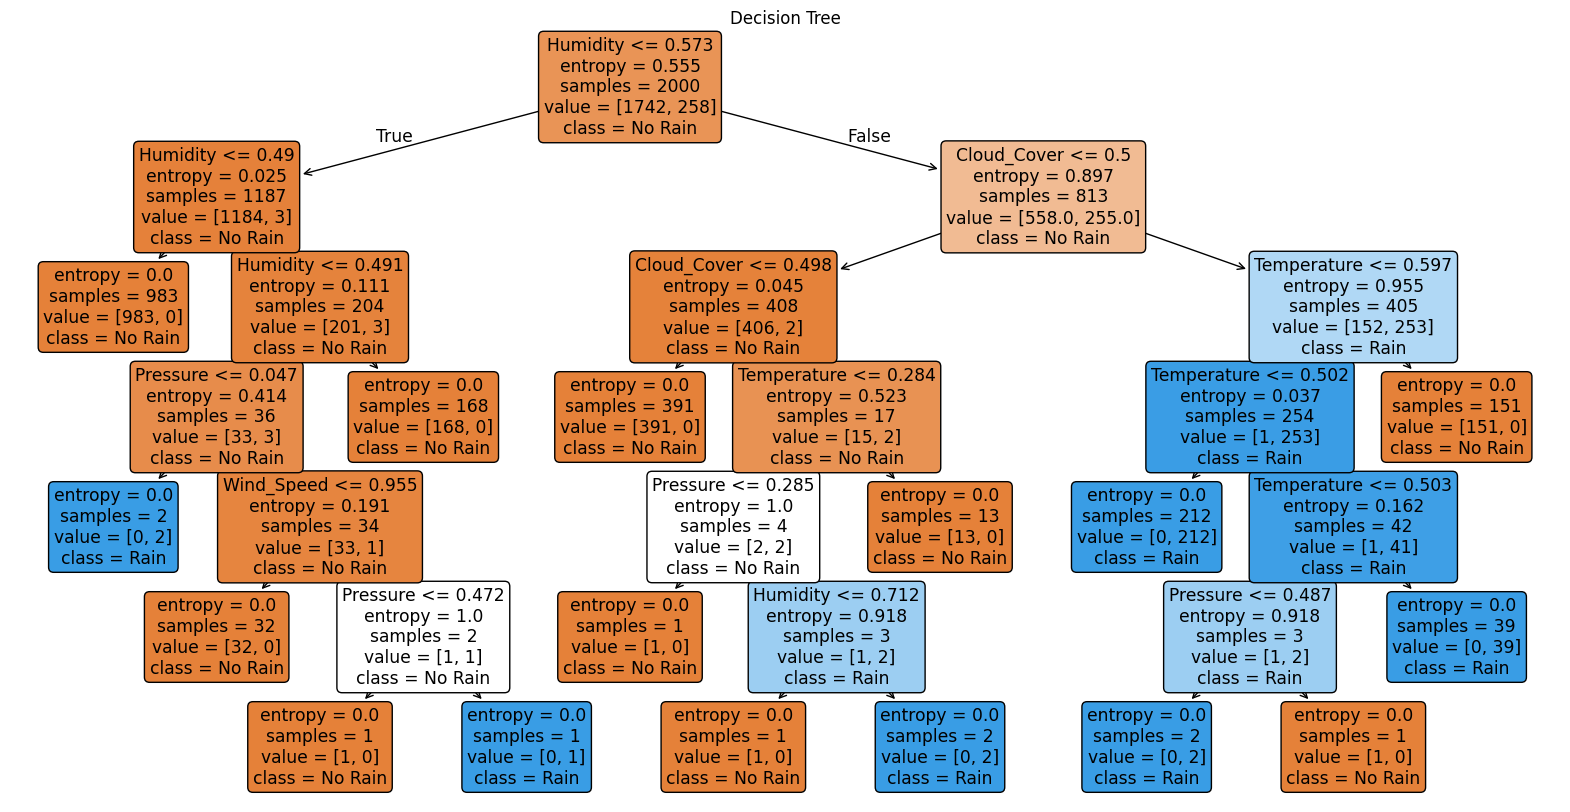

In [20]:
#for Avgerage-Filled
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model_avg, 
    feature_names=df_features_filled_avg.columns, 
    class_names=["No Rain", "Rain"], 
    filled=True, 
    rounded=True
)
plt.title("Decision Tree")
plt.show()
    


>#### Naive Bayes Algorithm

In [21]:
# initialize the classifer
model = GaussianNB()

>#### Model the features with avg replacement

In [22]:
# fit the model
model.fit(df_features_train_avg, df_targets_train_avg)

# predict the target values
y_pred_avg = model.predict(df_features_test_avg)

# evaluate the target values
print("Avg data:")

nb_accuracy_avg , nb_precision_avg , nb_recall_avg = evaluateModels(df_targets_test_avg ,y_pred_avg )


Avg data:
Accuracy: 96.60% Precision: 100.00% Recall: 69.64%


>#### Model the features with dropped nulls

In [23]:
# fit the model
model.fit(df_features_train_dropped , df_targets_train_dropped)

# predict the target values
y_pred_dropped = model.predict(df_features_test_dropped)

# evaluate the target values
print("Dropped Nulls data:")

nb_accuracy_dropped , nb_precision_dropped , nb_recall_dropped = evaluateModels(df_targets_test_dropped ,y_pred_dropped )



Dropped Nulls data:
Accuracy: 96.38% Precision: 100.00% Recall: 75.00%


## Compare between Decision Tree, k-Nearest Neighbors (kNN) and naïve Bayes

> #### Compare the performance of your implementations by evaluating accuracy, precision, and recall metrics. 

In [24]:


data = {
    "Model": [
        "KNN(K=5) ",
        "Decision Tree ",
        "Naive Bayes "
    ],
    "Accuracy (%)": [knn_accuracy_avg, dt_accuracy_avg, nb_accuracy_avg],
    "Precision (%)": [knn_precision_avg, dt_precision_avg, nb_precision_avg],
    "Recall (%)": [knn_recall_avg, dt_recall_avg, nb_recall_avg]
}


comparison_table = pd.DataFrame(data)

print("\nComparison of Models (Replacing Nulls with Mean)\n")
print(comparison_table)


Comparison of Models (Replacing Nulls with Mean)

            Model  Accuracy (%)  Precision (%)  Recall (%)
0       KNN(K=5)           96.8      91.666667   78.571429
1  Decision Tree           99.6     100.000000   96.428571
2    Naive Bayes           96.6     100.000000   69.642857


>#### compare the performance of your custom kNN implementation with the pre-built kNN algorithms in scikit-learn

In [25]:


data = {
    "Model": [
        "KNN (Scratch Implementation)",
        "KNN (Library Implementation)"
    ],
    "Accuracy (%)": [knn5_scratch_accuracy, knn_accuracy_avg],
    "Precision (%)": [knn5_scratch_precision, knn_precision_avg],
    "Recall (%)": [knn5_scratch_recall, knn_recall_avg]
}

comparison_table = pd.DataFrame(data)

print("\nComparison of KNN Implementations\n")
print(comparison_table)




Comparison of KNN Implementations

                          Model  Accuracy (%)  Precision (%)  Recall (%)
0  KNN (Scratch Implementation)          96.8      91.666667   78.571429
1  KNN (Library Implementation)          96.8      91.666667   78.571429


> #### evaluating the performance of scikit learn implementations of 3 algorithms with respect to the different handling missing data technique. 


In [26]:
data = {
    "Model": [
        "KNN(K=5) ",
        "Decision Tree ",
        "Naive Bayes "
    ],
    "Accuracy (%)": [knn_accuracy_avg, dt_accuracy_avg, nb_accuracy_avg],
    "Precision (%)": [knn_precision_avg, dt_precision_avg, nb_precision_avg],
    "Recall (%)": [knn_recall_avg, dt_recall_avg, nb_recall_avg]
}


comparison_table = pd.DataFrame(data)

print("\nComparison of Models (Replacing Nulls with Mean)\n")
print(comparison_table)


data = {
    "Model": [
        "KNN(K=5) ",
        "Decision Tree ",
        "Naive Bayes "
    ],
    "Accuracy (%)": [knn_accuracy_dropped, dt_accuracy_dropped, nb_accuracy_dropped],
    "Precision (%)": [knn_precision_dropped, dt_precision_dropped, nb_precision_dropped],
    "Recall (%)": [knn_recall_dropped, dt_recall_dropped, nb_recall_dropped]
}


comparison_table = pd.DataFrame(data)

print("\nComparison of Models (Dropping Nulls)\n")
print(comparison_table)


Comparison of Models (Replacing Nulls with Mean)

            Model  Accuracy (%)  Precision (%)  Recall (%)
0       KNN(K=5)           96.8      91.666667   78.571429
1  Decision Tree           99.6     100.000000   96.428571
2    Naive Bayes           96.6     100.000000   69.642857

Comparison of Models (Dropping Nulls)

            Model  Accuracy (%)  Precision (%)  Recall (%)
0       KNN(K=5)      95.957447      88.888889   82.352941
1  Decision Tree     100.000000     100.000000  100.000000
2    Naive Bayes      96.382979     100.000000   75.000000


> #### evaluating the performance of your implementations of the k-Nearest Neighbors (kNN) from scratch with different k values at least 5 values. 



> #### Compare these results with the performance of the corresponding algorithms implemented using scikit-learn. 

In [27]:

data = {
    "Model": [
        "KNN (Scratch, K=3)",
        "KNN (Scratch, K=5)",
        "KNN (Scratch, K=7)",
        "KNN (Scratch, K=9)",
        "KNN (Scratch, K=11)",
        "KNN (scikit-learn, K=5)",
        "Decision Tree",
        "Naive Bayes"
      
    ],
    "Accuracy (%)": [
        knn3_scratch_accuracy, knn5_scratch_accuracy,
        knn7_scratch_accuracy, knn9_scratch_accuracy,
        knn11_scratch_accuracy,
        knn_accuracy_avg, dt_accuracy_avg, nb_accuracy_avg
       
    ],
    "Precision (%)": [
        knn3_scratch_precision, knn5_scratch_precision,
        knn7_scratch_precision, knn9_scratch_precision,
        knn11_scratch_precision,
        knn_precision_avg, dt_precision_avg, nb_precision_avg
      
    ],
    "Recall (%)": [
        knn3_scratch_recall, knn5_scratch_recall,
        knn7_scratch_recall, knn9_scratch_recall,
        knn11_scratch_recall,
        knn_recall_avg, dt_recall_avg, nb_recall_avg
        
    ]
}

comparison_table = pd.DataFrame(data)

print("\nComparison of Models (Including KNN from Scratch with Various K Values)\n")
print(comparison_table)





Comparison of Models (Including KNN from Scratch with Various K Values)

                     Model  Accuracy (%)  Precision (%)  Recall (%)
0       KNN (Scratch, K=3)          97.2      90.384615   83.928571
1       KNN (Scratch, K=5)          96.8      91.666667   78.571429
2       KNN (Scratch, K=7)          96.4      88.000000   78.571429
3       KNN (Scratch, K=9)          96.6      88.235294   80.357143
4      KNN (Scratch, K=11)          97.2      90.384615   83.928571
5  KNN (scikit-learn, K=5)          96.8      91.666667   78.571429
6            Decision Tree          99.6     100.000000   96.428571
7              Naive Bayes          96.6     100.000000   69.642857
